In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [16]:
input_image_path = '/Users/phamminhtuan/Desktop/AIChallenge/IMG_1581_iter_0.jpg' 
output_image_path = '/Users/phamminhtuan/Desktop/AIChallenge/output2.jpg' 

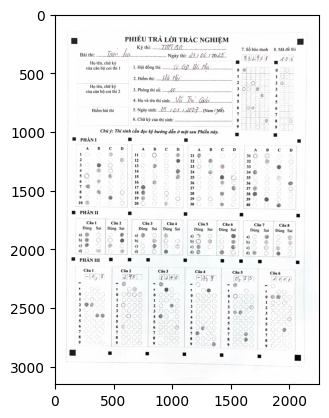

In [17]:
image = cv2.imread(input_image_path)
plt.imshow(image)

In [18]:
gray = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)

True

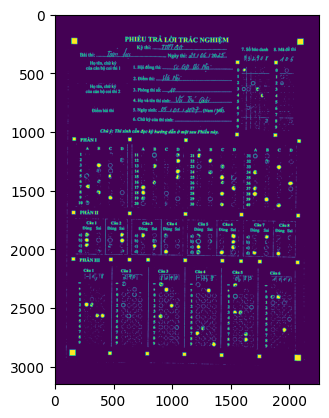

In [ ]:
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh)
cv2.imwrite('/Users/phamminhtuan/Desktop/AIChallenge/thresh.jpg', thresh)